In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

import numpy as np
from ipcc_colormap import *

import geopandas as gpd
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from cartopy.io.img_tiles import Stamen
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from matplotlib.patches import Circle
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase
from matplotlib import gridspec
from utils import *

coastline = gpd.read_file('/home/mizu_home/xp53/nas/home/coastlines-split-SGregion/lines.shp')
mask = np.loadtxt('mask.txt')

ipcc_blue = (112.0/255, 160.0/255, 205.0/255, 1.0)
ipcc_orange = (196.0/255, 121.0/255, 0.0/255, 1.0)

tmp_cmap = ipcc_cmap()
tmp_cmap.read_rgb_data_from_excel()
;

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


''

In [3]:
# DATA PREPARATION
# the station-based rainfall data is already organized in a N by P matrix
rain_obs = np.loadtxt('data/sta_monthly.csv')

# the simulated rainfall data is reshaped to a 2d matrix of size N by (W x L)
rain_sim_flatten = np.loadtxt('data/wrf_monthly.csv')
rain_sim = rain_sim_flatten.reshape(rain_sim_flatten.shape[0], 120, 160)

# sim_sel constains a P by 4 matrix
# the first two columns are the row and column indices of grids corresponding to the stations
# the last two columns are the lons and lats of grids corresponding to the stations
sim_sel = np.loadtxt('data/wrf_loc.csv')
sim_idx = sim_sel[:, :2].astype(int)

# select simulated rainfall at stations
wrf_sta = np.array([rain_sim[:, i, j] for (i, j) in sim_idx]).T

# lats and lons of all grids are stored in a 2d matrix of 2 by (W x L)
# the first row is lons and the second row is lats
longlat = np.loadtxt('data/lonlat.txt')
lons = longlat[0, :].reshape(120, 160)
lats = longlat[1, :].reshape(120, 160)

# read station lons (3rd column) and lats (4th column)
sta_loc = np.genfromtxt('data/sta_lookup_new.csv', delimiter=',')[:, 2:]

# read wrf simulated rainfall forced by cmip6 future climate
cmip_rain_f = np.loadtxt('data/wrf_monthly_cmip.txt')[-40:, :]
cmip_rain0 = cmip_rain_f.reshape(cmip_rain_f.shape[0], 12, 120, 160)
cmip_rain = np.zeros(cmip_rain0.shape)
cmip_rain[:, 0:6, :, :] = cmip_rain0[:, 6:12, :, :]
cmip_rain[:, 6:12, :, :] = cmip_rain0[:, 0:6, :, :]
cmip_rain_flatten = np.reshape(cmip_rain, (40, 12, 120*160))
wrf_sta_fut = np.zeros((40, 12, sim_idx.shape[0]))
for idx, (i, j) in enumerate(sim_idx):
    wrf_sta_fut[:, :, idx] = cmip_rain[:, :, i, j]

In [8]:
cmip_rain.shape

(40, 12, 120, 160)

In [ ]:
# interpolate to all grids
gpr_ = gp_interpolator(P = sim_idx.shape[0])

sg_plotter = sg_map_plotter(lons, lats, coastline)
cmap = tmp_cmap.get_ipcc_cmap('seq', 'prec', 20)

fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(4, 3, height_ratios=[1,1,1,1], bottom=0.1, top=0.95, left=0.05, right=0.95,
                       wspace=0.05, hspace=0.05)  # Leave space at the bottom for the colorbar

axes = [plt.subplot(gs[i, j], projection=crs.PlateCarree()) for i in range(4) for j in range(3)]

for i, ax in enumerate(axes):
    t1 = time.time()
    tmp_mu = np.mean(rain_sim[i::12, :, :], axis = 0)
    print(np.nanmax(tmp_mu))
    sg_plotter.plot_(ax, tmp_mu, cmap = cmap, vmin = 0, vmax = 480)
    sg_plotter.plot_scatter(ax, sta_loc, size = 15)
    print(f'{i+1}th month: {time.time() - t1:.2f} sec, the min and max are {np.min(tmp_mu):.2f} and {np.max(tmp_mu):.2f}')

# Adjust the colorbar placement
cbar_ax = fig.add_axes([0.06, 0.07, 0.88, 0.015])  # Position: [left, bottom, width, height]
bounds = np.linspace(0, 400, 21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=12)
# make label font larger and bold
cb.set_label('Rainfall Climatology [mm]', fontsize=12, fontweight='bold')

fig.savefig('for_pub/wrf_his.pdf')


239.6847686767578
1th month: 0.62 sec, the min and max are 0.00 and 239.68
166.1749710083008
2th month: 0.62 sec, the min and max are 0.00 and 166.17
251.8987243652344
3th month: 0.64 sec, the min and max are 0.00 and 251.90
303.9559600830078
4th month: 0.75 sec, the min and max are 0.00 and 303.96
289.202587890625
5th month: 0.87 sec, the min and max are 0.00 and 289.20
211.93334350585937
6th month: 1.00 sec, the min and max are 0.00 and 211.93
202.21268963813782
7th month: 1.12 sec, the min and max are 0.00 and 202.21
164.1838821411133
8th month: 1.24 sec, the min and max are 0.00 and 164.18
159.5697334289551
9th month: 1.65 sec, the min and max are 0.00 and 159.57
213.7068950653076
10th month: 1.48 sec, the min and max are 0.00 and 213.71
412.53064193725584
11th month: 1.60 sec, the min and max are 0.00 and 412.53
401.6072410583496
12th month: 1.69 sec, the min and max are 0.00 and 401.61


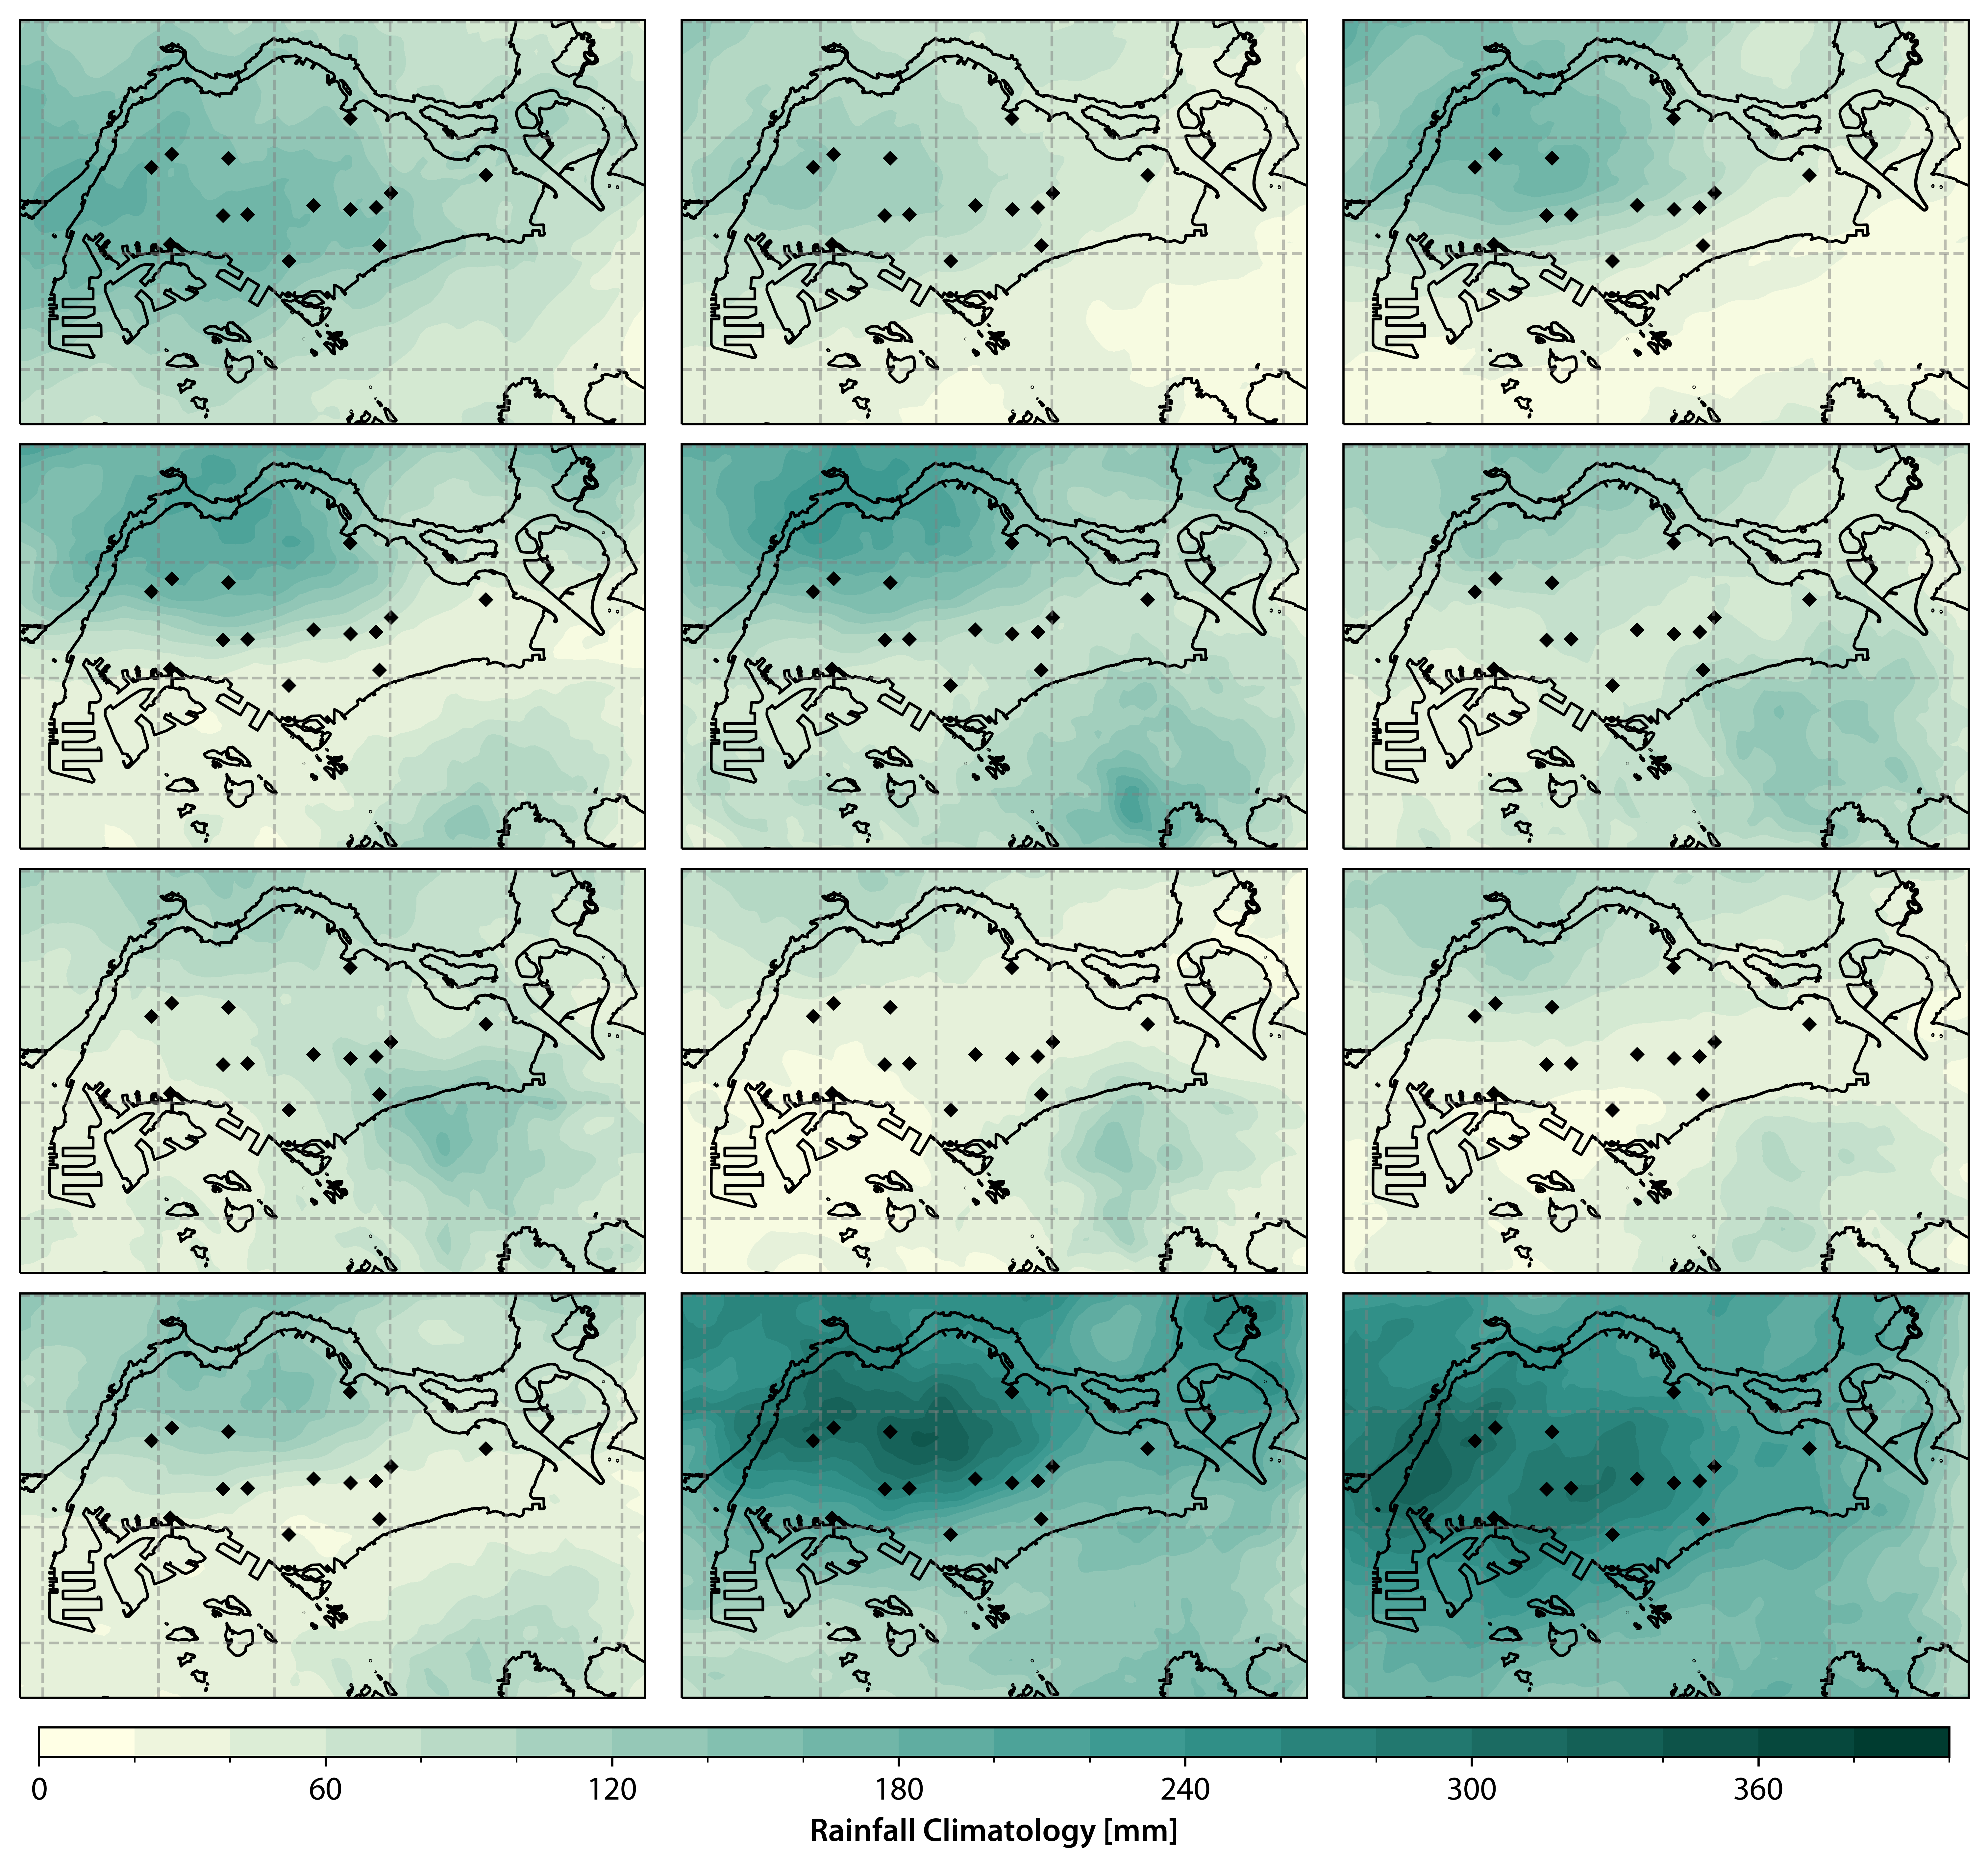

In [9]:
# interpolate to all grids
gpr_ = gp_interpolator(P = sim_idx.shape[0])

sg_plotter = sg_map_plotter(lons, lats, coastline)
cmap = tmp_cmap.get_ipcc_cmap('seq', 'prec', 20)

fig = plt.figure(figsize=(11, 10))
gs = gridspec.GridSpec(4, 3, height_ratios=[1,1,1,1], bottom=0.1, top=0.95, left=0.05, right=0.95,
                       wspace=0.05, hspace=0.05)  # Leave space at the bottom for the colorbar

axes = [plt.subplot(gs[i, j], projection=crs.PlateCarree()) for i in range(4) for j in range(3)]

for i, ax in enumerate(axes):
    t1 = time.time()
    tmp_mu = np.mean(cmip_rain[:,i,:,:], axis = 0)
    print(np.nanmax(tmp_mu))
    sg_plotter.plot_(ax, tmp_mu, cmap = cmap, vmin = 0, vmax = 480)
    sg_plotter.plot_scatter(ax, sta_loc, size = 15)
    print(f'{i+1}th month: {time.time() - t1:.2f} sec, the min and max are {np.min(tmp_mu):.2f} and {np.max(tmp_mu):.2f}')

# Adjust the colorbar placement
cbar_ax = fig.add_axes([0.06, 0.07, 0.88, 0.015])  # Position: [left, bottom, width, height]
bounds = np.linspace(0, 400, 21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.ax.tick_params(labelsize=12)
# make label font larger and bold
cb.set_label('Rainfall Climatology [mm]', fontsize=12, fontweight='bold')

fig.savefig('for_pub/wrf_fut.pdf')


Text(0, 0.5, 'SPI')

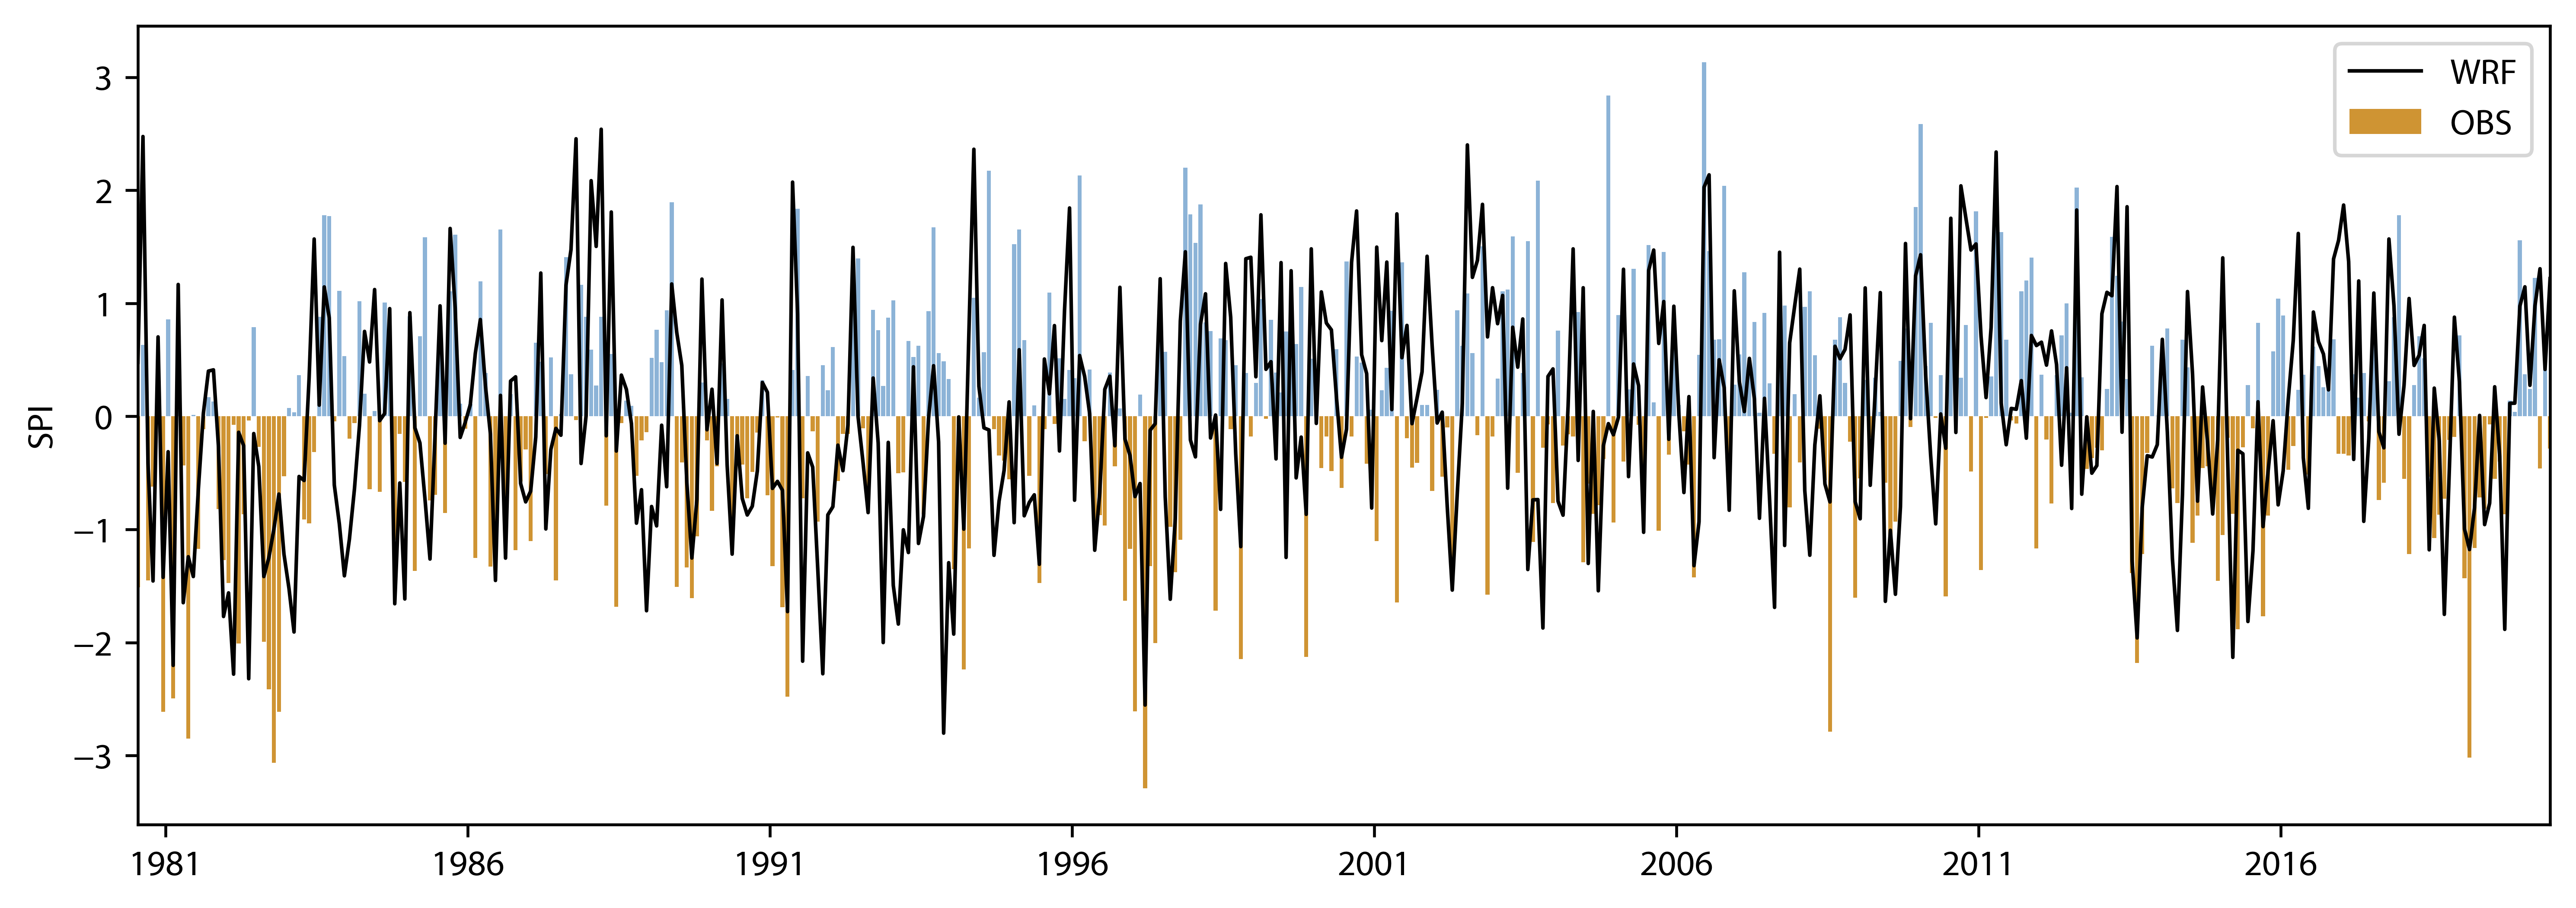

In [28]:
import scipy.stats as ss

rain_sta = np.mean(np.loadtxt('data/sta_monthly.csv'), axis = 1)
rain_wrf = np.loadtxt('data/wrf_monthly.csv').reshape(-1, 120, 160)
rain_wrf = np.nanmean(rain_wrf * mask, axis = (1, 2))

wrf_spi = np.zeros([12*40, 1])
sta_spi = np.zeros([12*40, 1])
para = {}
sta_para = {}

for mm in range(12):
    para[mm] = ss.gamma.fit(rain_wrf[mm::12], floc = 0)
    tmpcdf = ss.gamma.cdf(rain_wrf[mm::12], a=para[mm][0], loc=0, scale=para[mm][2])
    wrf_spi[mm::12] = ss.norm.ppf(tmpcdf).reshape(-1, 1)

    sta_para[mm] = ss.gamma.fit(rain_sta[mm::12], floc = 0)
    sta_tmpcdf = ss.gamma.cdf(rain_sta[mm::12], a=sta_para[mm][0], loc=0, scale=sta_para[mm][2])
    sta_spi[mm::12] = ss.norm.ppf(sta_tmpcdf).reshape(-1, 1)
    
fig = plt.figure(figsize=(12,4))

ax = plt.subplot(1,1,1)
x_neg = [i for i in range(12*40) if sta_spi[i] < 0 ]
x_pos = [i for i in range(12*40) if sta_spi[i] > 0 ]
ax.bar(x_neg, [sta_spi[i][0] for i in range(12*40) if sta_spi[i] < 0 ], color=ipcc_orange, alpha=0.8, edgecolor=None, label='OBS')
ax.bar(x_pos, [sta_spi[i][0] for i in range(12*40) if sta_spi[i] > 0 ], color=ipcc_blue, alpha=0.8, edgecolor=None)
ax.plot(range(12*40), wrf_spi, 'k', linewidth=1, label='WRF')
ax.set_xticks([i + 5.5 for i in range(0, 12*40, 12*5)])
ax.set_xticklabels([str(i) for i in range(1981, 2021, 5)])
ax.legend()
ax.set_xlim([0, 12*40-1])
plt.ylabel('SPI')

In [29]:
np.corrcoef([sta_spi.flatten(), wrf_spi.flatten()])

array([[1.        , 0.39687885],
       [0.39687885, 1.        ]])